In [4]:
import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import ot
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import *
from tqdm import trange, tqdm
import time
import tree_estimators as te
import ot_estimators as ote
from utils import *
import torch.multiprocessing as tmp
import multiprocessing as mp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from ot_tree import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import sys
from scipy.stats import mode
import pickle

In [5]:
vecs = np.array([[0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1]], dtype=np.float32)
qt_solver = ote.OTEstimators()
qt_solver.load_vocabulary(vecs)

In [8]:
qt_solver.return_parent_details()

[-1, 0, 0, 0, 0]

# CPU Optimization

In [46]:
def tree_reconstruction_task(n=10, device='cuda:4', num_dists=10, G=None, train_weights=False, prior=[]):
    if G == None:
        tree = nx.random_tree(n=n)
    else:
        tree = G
        n = len(list(tree.nodes))
    nodes = list(tree.nodes)
    # find all leaf nodes
    leaves = []
    for node in range(len(nodes)):
        deg = tree.degree[node]
        if deg == 1:
            leaves.append(node)
    length = dict(nx.all_pairs_shortest_path_length(tree))
    n = len(leaves)

    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            D[i][j] = nx.shortest_path_length(tree, source=i, target=j, weight='weight')
            D[j][i] = D[i][j]
    A = np.random.normal(size=(n, n)) * 0.1
    D = D + A@A.T
    D[[0, 1, 2, 3], [0,1, 2, 3]] = 0.0

    if len(prior) != 0:
        tree = GPUOptimizedTree(prior, device=device)
    else:
        tree = GPUOptimizedTree(D, device=device)
    tree.to(device)
    #id = np.identity(n) 
    train_distributions = generate_random_dists(num_dists, n)
    
    #train_distributions = np.concatenate((train_distributions, id), axis=0)
    #train_distributions = np.identity(n)
    num_dists = len(train_distributions)
    x = []
    y = []
    d = []
    for i in range(num_dists):
        for j in range(i + 1, num_dists):
            a = train_distributions[i]
            b = train_distributions[j]
            otdistance=ot.emd2(a, b, D)
            x.append(i)
            y.append(j)
            d.append(otdistance)
    dataset = DistanceDataset(torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long),  torch.tensor(d))
    dataloader = DataLoader(dataset, batch_size=len(x), shuffle=True)
    print(tree.parameters())
    optimizer = torch.optim.SGD(tree.parameters(), lr = 0.001)
    if not train_weights:
        tree.train(dataloader, optimizer, train_distributions, max_iterations=200, plt_name='/data/sam/test', bsz=1)
    else:
        tree.train_weights(dataloader,optimizer,train_distributions,max_iterations=100, plt_name='/data/sam/test', bsz=1)
    # print(tree.parents)
    # print(tree.leaves)
    # print(tree.param)
    return tree, D



In [7]:
# Generate 5 random trees
tree_dataset = []
for i in range(5):
    n = np.random.randint(low=20, high=40)
    tree = nx.random_tree(n=n)
    tree_dataset.append(tree)

100%|██████████| 5/5 [01:16<00:00, 15.34s/it]


Average: 0.6531283828024872 std.dev 0.1697113846313793


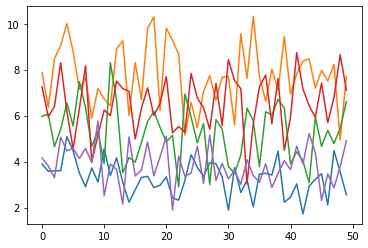

In [8]:
diffs = []
for i in trange(5):
    tree = tree_dataset[i]
    tree, D = tree_reconstruction_task(G=tree, device='cuda:6', num_dists=80)
    weights = tree.param.detach().cpu().numpy()
    learned_distance = weights[tree.M_idx]
    diffs.append(2/(D.shape[0]*(D.shape[0]-1))*np.linalg.norm(learned_distance - D, ord='fro'))
print("Average:", np.mean(diffs), "std.dev", np.std(diffs))

100%|██████████| 5/5 [01:37<00:00, 19.47s/it]


Average: 0.6531269033380879 std.dev 0.16968474950070045


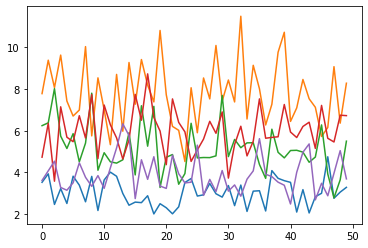

In [10]:
diffs = []
for i in trange(5):
    tree = tree_dataset[i]
    tree, D = tree_reconstruction_task(G=tree, device='cuda:6', num_dists=80, train_weights=True)
    weights = tree.param.detach().cpu().numpy()
    learned_distance = weights[tree.M_idx]
    diffs.append(2/(D.shape[0]*(D.shape[0]-1))*np.linalg.norm(learned_distance - D, ord='fro'))
print("Average:", np.mean(diffs), "std.dev", np.std(diffs))

  2%|▏         | 3/200 [00:00<00:06, 29.91it/s]

<generator object Module.parameters at 0x7fa0a2171890>
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


  4%|▍         | 9/200 [00:00<00:06, 27.35it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


  6%|▌         | 12/200 [00:00<00:17, 10.95it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]

  8%|▊         | 17/200 [00:01<00:12, 14.91it/s]


[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 12%|█▏        | 23/200 [00:01<00:10, 17.33it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 15%|█▌        | 30/200 [00:01<00:07, 22.79it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]

 17%|█▋        | 34/200 [00:01<00:06, 25.63it/s]


[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 19%|█▉        | 38/200 [00:01<00:05, 27.20it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 22%|██▏       | 44/200 [00:02<00:09, 16.46it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 24%|██▎       | 47/200 [00:02<00:09, 16.41it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]

 26%|██▌       | 52/200 [00:02<00:08, 18.03it/s]


[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 28%|██▊       | 55/200 [00:03<00:07, 18.94it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 30%|███       | 61/200 [00:03<00:07, 19.67it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 32%|███▏      | 64/200 [00:03<00:06, 20.71it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 34%|███▎      | 67/200 [00:03<00:06, 21.82it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 37%|███▋      | 74/200 [00:04<00:07, 16.30it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 38%|███▊      | 77/200 [00:04<00:06, 18.60it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 42%|████▏     | 83/200 [00:04<00:06, 18.62it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]

 44%|████▍     | 89/200 [00:04<00:05, 21.58it/s]


[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 48%|████▊     | 97/200 [00:05<00:03, 26.99it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 52%|█████▏    | 104/200 [00:05<00:05, 19.04it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 56%|█████▌    | 111/200 [00:05<00:04, 21.78it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 57%|█████▊    | 115/200 [00:06<00:03, 24.28it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 61%|██████    | 122/200 [00:06<00:03, 24.64it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 64%|██████▍   | 128/200 [00:06<00:02, 24.34it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 66%|██████▌   | 131/200 [00:06<00:03, 19.67it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 67%|██████▋   | 134/200 [00:07<00:05, 11.98it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]

 70%|██████▉   | 139/200 [00:07<00:04, 14.62it/s]


[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 72%|███████▎  | 145/200 [00:07<00:02, 18.66it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 76%|███████▋  | 153/200 [00:07<00:01, 25.46it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 80%|████████  | 161/200 [00:08<00:01, 29.07it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 82%|████████▎ | 165/200 [00:08<00:02, 15.41it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 86%|████████▌ | 171/200 [00:09<00:01, 17.37it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 89%|████████▉ | 178/200 [00:09<00:00, 22.26it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 91%|█████████ | 182/200 [00:09<00:00, 24.60it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 92%|█████████▎| 185/200 [00:09<00:00, 22.00it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


 96%|█████████▌| 191/200 [00:09<00:00, 20.35it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


100%|██████████| 200/200 [00:10<00:00, 19.02it/s]

[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]
[ 6  5  4  4  5  6 -1]


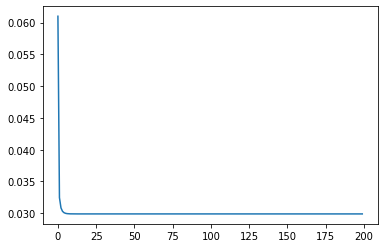

In [47]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
G.add_edge(0, 4, weight=1)
G.add_edge(3, 4, weight=1)
G.add_edge(1, 5, weight=1)
G.add_edge(2, 5, weight=1)
G.add_edge(4, 6, weight=0.01)
G.add_edge(5, 6, weight=0.01)
pmat = [[0, 1, 1, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 1, 1, 0]]
prior = np.array(pmat, dtype=np.float32)
learned_tree, D = tree_reconstruction_task(G=G, num_dists=50)
weights = learned_tree.param.detach().cpu().numpy()



In [48]:
def construct_nx_tree(parents, leaves, weights):
    G = nx.Graph()
    for i in range(len(parents)):
        weight = 0.5*(weights[parents[i]] - weights[i])
        G.add_node(i)
        if parents[i] != -1:
            w = round(weight, 2)
            G.add_edge(i, parents[i], weight=w)
    return G

        

100%|██████████| 7/7 [00:00<00:00, 16513.01it/s]

[0.         0.         0.         0.         2.00194533 2.01592882
 2.0201279 ]
[ 6  5  4  4  5  6 -1]
[0 1 2 3]


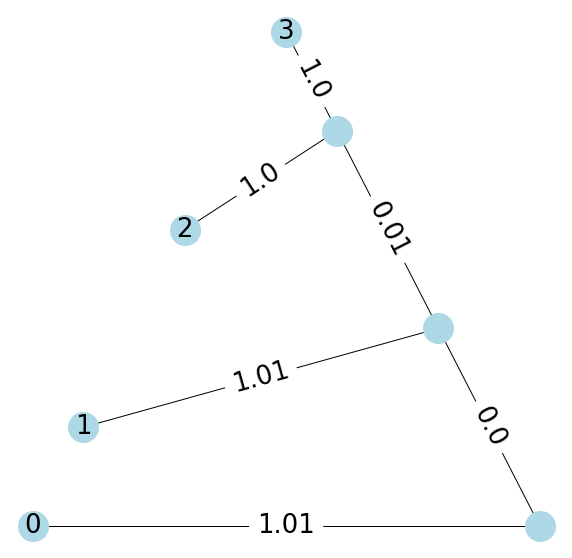

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
optimized_tree = learned_tree
weights = optimized_tree.param.detach().cpu().numpy()
print(weights)
print(optimized_tree.parents)
print(optimized_tree.leaves)
opttree = construct_nx_tree(optimized_tree.parents, optimized_tree.leaves, weights)
labels = nx.get_edge_attributes(opttree, 'weight')
pos = nx.planar_layout(opttree)
nlabels = {}
count = 0
for node in trange(len(opttree.nodes)):
    deg = opttree.degree[node]
    if deg == 1:
        nlabels[node] = node
        count += 1
nx.draw(opttree,pos, with_labels=False, ax=ax, node_color='#ADD8E6', node_size=900)
nx.draw_networkx_labels(opttree,pos,nlabels,font_size=26, ax=ax)
lbl=nx.draw_networkx_edge_labels(opttree,pos,edge_labels=labels,font_size=26, ax=ax)

100%|██████████| 20/20 [00:00<00:00, 42755.39it/s]


{(0, 15): Text(0.05144995915788132, 0.15209467054718614, '1'),
 (0, 18): Text(-0.11010451772690452, 0.023613207459602294, '1'),
 (0, 14): Text(-0.006426151686328352, -0.10813740357994368, '1'),
 (1, 4): Text(-0.46480830050389355, 0.03311540201779401, '1'),
 (2, 5): Text(-0.053794325292796985, 0.7394077060261042, '1'),
 (2, 8): Text(0.007045614119739349, 0.5808409401885156, '1'),
 (3, 7): Text(0.36244360152753263, 0.4454319554786573, '1'),
 (3, 6): Text(0.42778000240474046, 0.4083391535235008, '1'),
 (3, 15): Text(0.22232713863565884, 0.3325115493192651, '1'),
 (4, 18): Text(-0.3012222977603897, 0.026426171431557805, '1'),
 (6, 16): Text(0.5939287332862577, 0.4575413378342935, '1'),
 (8, 15): Text(0.07700366649431013, 0.38606259280225547, '1'),
 (9, 14): Text(0.0525018773298181, -0.2787596408749127, '1'),
 (10, 15): Text(0.06394506518524926, 0.30250194358967686, '1'),
 (11, 12): Text(-0.2685261095862535, -0.8977384578700918, '1'),
 (12, 17): Text(-0.20076548967106123, -0.928412029280780

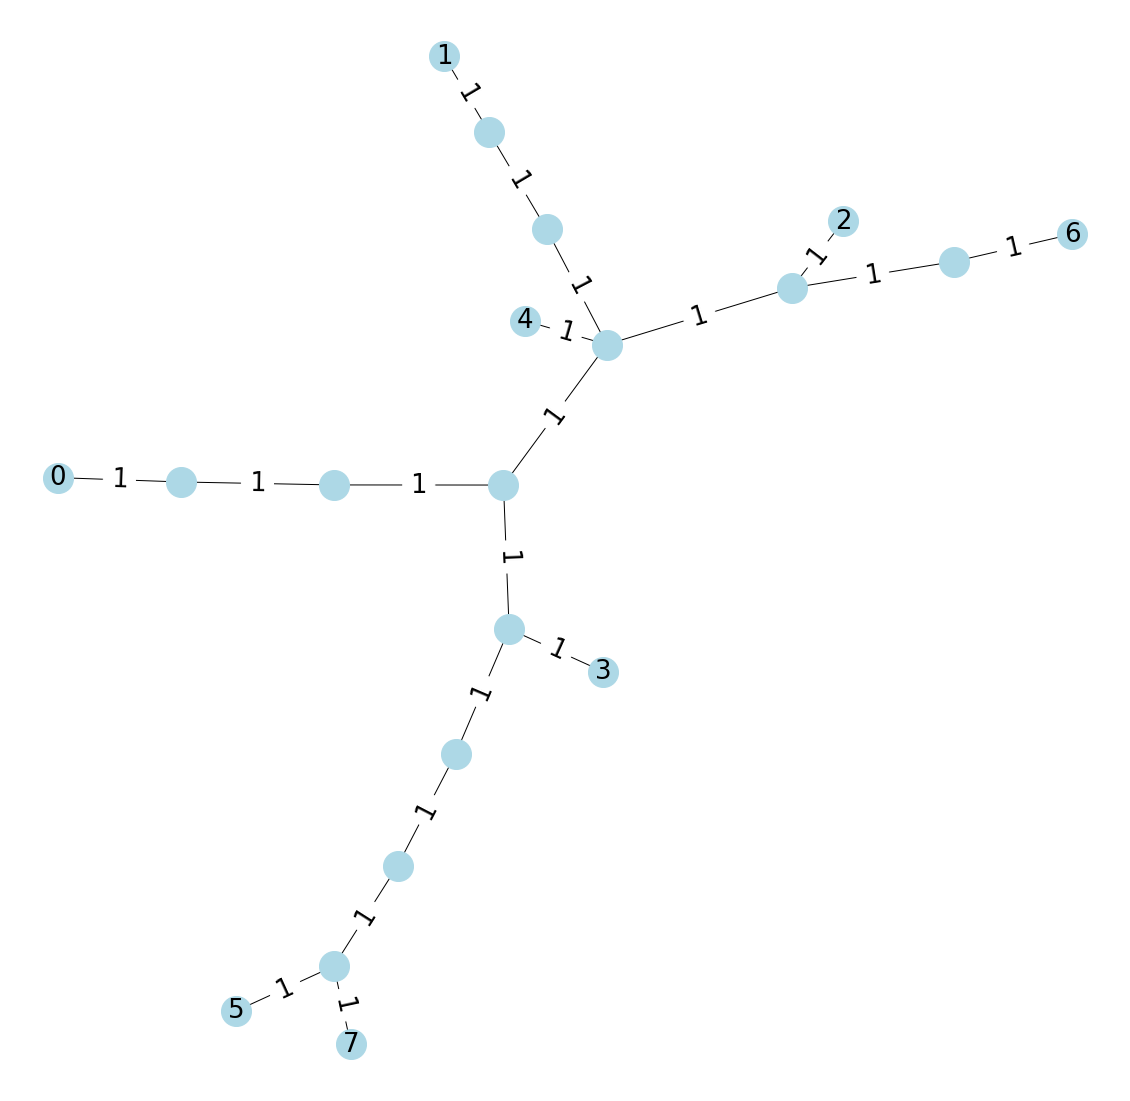

In [18]:
tree = nx.random_tree(n=20, seed=1)
fig, ax = plt.subplots(figsize=(20, 20))
pos = nx.spring_layout(tree)
nodes = list(tree.nodes)
# find all leaf nodes
labels = {}
count = 0
for node in trange(len(nodes)):
    deg = tree.degree[node]
    if deg == 1:
        labels[node] = count
        count += 1
nx.set_edge_attributes(tree, values = 1, name = 'weight')
elabels = nx.get_edge_attributes(tree, 'weight')


nx.draw(tree, pos, with_labels=False,node_color='#ADD8E6', node_size=900)

nx.draw_networkx_labels(tree,pos,labels,font_size=26)
nx.draw_networkx_edge_labels(tree,pos,edge_labels=elabels,font_size=26)

In [6]:
import itertools

def average_error(parents, leaves, parameters, subtree, dataset):
    print("Loading data.......")
    word_vecs = np.load('/data/sam/' + dataset + '/vectors.npy')
    word_vecs.astype(np.float32)
    documents = np.load('/data/sam/'+ dataset + '/distributions.npy')
    D = np.load("/data/sam/" + dataset + '/distance_matrix.npy')
    D = D/D.max()
    word_vecs = word_vecs/D.max()
    train_indices = np.load("/data/sam/" + dataset + '/test_idx_test30_rs24.npy')
    train_idx = np.load('/data/sam/twitter/train_idx.npy')
    test_indices = []
    for i in range(len(documents)):
        if i not in train_indices:
            test_indices.append(i)
    test_documents = documents[train_indices]
    # format test documents
    formatted_test_docs = []
    for distribution in tqdm(test_documents):
        formatted_test_docs.append(format_distributions(distribution))
    print("Number of test documents:", len(formatted_test_docs))

    qt_solver = ote.OTEstimators()
    qt_solver.load_vocabulary(word_vecs)

    opt_tree = np.zeros((len(test_documents), len(test_documents)))
    ft = np.zeros((len(test_documents), len(test_documents)))
    qt = np.zeros((len(test_documents), len(test_documents)))
    ot_d = np.zeros((len(test_documents), len(test_documents)))
    
    opt_time = []
    ft_time = []
    qt_time = []
    sinkhorn_time = []

    print("Computing optimized tree wasserstein distances")
    combos = itertools.combinations(np.arange(len(test_documents)), 2)
    l = list(combos)
    indices = [list(t) for t in zip(*l)]
    A = test_documents[indices[0]].transpose()
    B = test_documents[indices[1]].transpose()
    print(".... beginning batch computations ....")
    start = time.time()
    batches_numbers = len(indices[0])//200
    batch_results = []
    for i in trange(batches_numbers):
        if i == batches_numbers:
            a = A[:, i * 200: ]
            b = B[:, i * 200: ]
            approx = batch_calc_twd(parents, parameters, subtree, a, b)
            batch_results.append(approx)
        else:
            a = A[:, i*200: (i + 1)*200]
            b = A[:, i*200: (i + 1)*200]
            approx= batch_calc_twd(parents, parameters, subtree, a, b)
            batch_results.append(approx)
    #opt_tree_results = batch_calc_twd(parents, parameters, subtree, A, B)
    end = time.time()
    opt_tree_time = end - start
    opt_tree_results = np.concatenate(batch_results)
    fname = '/data/sam/' + dataset + '/results/approximations.npy'
    np.save(fname, opt_tree_results)
    print(opt_tree_results.shape)
    count = 0
    for i in trange(len(test_documents)):
        for j in range(i + 1, len(test_documents)):
            opt_tree[i][j] = opt_tree_results[count]
            opt_tree[j][i] = opt_tree_results[count]
            count += 1

    print("Computing real optimal transport distance")
    pool = mp.Pool(processes=20)
    jobs = []
    for i in trange(len(test_documents)):
        for j in range(i + 1, len(test_documents)):
            d1 = documents[i]
            d2 = documents[j]
            combined_vec = d1 + d2
            non_zero_indices = np.nonzero(combined_vec)[0]
            small_D = D[non_zero_indices][:, non_zero_indices]
            job = pool.apply_async(ot.emd2, args=(d1[non_zero_indices], d2[non_zero_indices], small_D))
            jobs.append(job)
    
    for job in tqdm(jobs):
        job.wait()
    results = [job.get() for job in jobs]
    count = 0
    for i in trange(len(test_documents)):
        for j in range(i + 1, len(test_documents)):
            result = results[count]
            ot_d[i][j] = result
            ot_d[j][i] = result
            count += 1
    


    print("Starting computations")
    for i in trange(len(test_documents)):
        for j in range(i + 1, len(test_documents)):

            start = time.time()
            ft[i][j] = qt_solver.flowtree_query(formatted_test_docs[i], formatted_test_docs[j])
            ft[j][i] = ft[i][j]
            end = time.time()
            ft_time.append(end - start)

            
            start = time.time()
            qt[i][j] = qt_solver.quadtree_distance(formatted_test_docs[i], formatted_test_docs[j])
            qt[j][i] = qt[i][j]
            end = time.time()
            qt_time.append(end - start)

    approximations = [ ft, qt]
    approx_times = [ft_time, qt_time]
    approx_names = ["Flowtree", "Quadtree"]
    #print("sinkhorn:", np.mean(sinkhorn_time))
    print("Optimal tree mean absolute error", np.mean(np.abs(opt_tree - ot_d)), "std. dev.:", np.std(np.abs(approximations[i] - ot_d)))
    print("------ Average time per document:", opt_tree_time/len(indices))
    for i in range(2):
        print(approx_names[i], "Mean absolute error:", np.mean(np.abs(approximations[i] - ot_d)), 
              "std dev.:", np.std(np.abs(approximations[i])))
        print("------- Average time per document:", np.mean(approx_times[i]), "std dev:", np.std(approx_times[i]))
    return ot_d, approximations

In [6]:
# takes approximation matrices where approx[i][j] = approx. distance between i and j
# order: optimized tree, flowtree, quadtree
def recall(approximations, real_distance, plt_name=None):
    names = ["OptimizedTree", "FlowTree", "QuadTree"]
    sorted_distances = np.argsort(real_distance, axis=1)
    top1 = sorted_distances[:, 1]
    all_recall = []
    for approx in approximations:
        approx_sort = np.argsort(approx, axis=1)
        candidates = approx_sort[:, 1:]
        recall = np.zeros(candidates.shape[1])
        for i in range(candidates.shape[0]):
            for j in range(1, 50):
                if top1[i] in candidates[i, :j]:
                    recall[j] += 1  
        all_recall.append(recall)  
    for i in range(len(all_recall)):
        recall= all_recall[i]
        plt.plot(np.arange(1, len(recall[:50])), recall[1:50], label=names[i])
    plt.legend()
#     print("SAVED at", plt_name)
#     plt.savefig(plt_name)
#    return all_recall

In [7]:
def kNN_experiment(metric, labels, k = 5):
    metric_sort = np.argsort(metric, axis=1)
    prediction_accuracy = 0
    for i in range(metric_sort.shape[0]):
        top_k = metric_sort[i, 1:k + 1]
        predict = mode(labels[top_k])[0][0]
        if predict == labels[i]:
            prediction_accuracy += 1
    return prediction_accuracy/len(labels)
    

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def svm(metric, labels, train_indices, t=1):
    test_indices = []
    for i in range(len(all_labels)):
        if i not in train_indices:
            test_indices.append(i)
    D_train, D_test = metric[train_indices][:, train_indices], metric[test_indices][:, train_indices]
    y_train, y_test = labels[train_indices], labels[test_indices]
    
    svc = SVC(kernel = 'precomputed')
    
    kernel_train = np.exp(-t * D_train)
    
    svc.fit(kernel_train, y_train)
    
    kernel_test = np.exp(-t * D_test)
    
    y_pred = svc.predict(kernel_test)
    return accuracy_score(y_test, y_pred)

In [7]:
# parents = np.load("/data/sam/twitter/results/30/t3/t3_parents.npy")
# leaves = np.load("/data/sam/twitter/results/30/t3/t3_leaves.npy")
# weights = np.load("/data/sam/twitter/results/30/t3/t3_parameters.npy")
# M_idx = np.load("/data/sam/twitter/results/30/t3/t3_Midx.npy")
model_info = torch.load('/data/sam/twitter/results/110.pt', map_location='cpu')
parents = model_info['parents']
leaves = model_info['leaves']
subtree = model_info['subtree'].numpy()
weights = model_info['optimized_state_dict']['param'].numpy()
ot_d, approximations = average_error(parents, leaves, weights, subtree, "twitter")
# np.save("/data/sam/bbc/results/30/t1/opt_tree_distances.npy", approximations[0])
# np.save("/data/sam/bbc/results/30/t1/flowtree_distance.npy", approximations[1])
# np.save("/data/sam/bbc/results/30/t1/quadtree_distance.npy", approximations[2])

Loading data.......


100%|██████████| 2170/2170 [00:09<00:00, 234.88it/s]


Number of test documents: 2170
Computing optimized tree wasserstein distances


  0%|          | 0/11766 [00:00<?, ?it/s]

.... beginning batch computations ....


 27%|██▋       | 3139/11766 [13:44<37:44,  3.81it/s]  


KeyboardInterrupt: 

In [17]:
print(approximations[0].shape)
print(ot_d.shape)
total = 0
count = 0
for i in trange(100):
    for j in range(i + 1, 100):
        if ot_d[i][j] > 0.00001:
            total += np.abs(approximations[0][i][j] - ot_d[i][j])/ot_d[i][j]
            count += 1
total/count

100%|██████████| 100/100 [00:00<00:00, 726.84it/s]

(300, 300)
(300, 300)


0.18181471626443646

100%|██████████| 10006/10006 [00:13<00:00, 739.41it/s]


In [65]:
words = np.load('/data/sam/bbc/words.npy')
#print(words)
for node in clustering:
    leaves = clustering[node]
    if len(leaves) > 1 and max(leaves) < 9758:
        print(words[leaves])
    # print(len(leaves))
    # print(words[leaves])

['medal' 'cl' 'feint']
['win' 'race' 'shock' 'cools']
['record' 'success' 'barged' 'abn']
['seconds' 'easily']
['won' 'patrick' '8km']
['domestic' 'grand' 'form' 'minute' 'reciprocate']
['equal' 'embarked' 'unreturnable']
['leap' '5' 'verdict']
['regime' 'richards']
['participate' 'cross' 'regain']
['athletics' 'undergo' 'greats']
['runner' 'decision']
['provincial' 'winner']
['marathon' 'april' 'dougie']
['participation' 'base' 'breaking']
['australia' 'team' 'assurances']
['9' 'nutrition' 'money']
['winning' 'catch' 'writers']
['american' 'biggest' 'mockery']
['crossed' 'misuse']
['sprints' 'finland' 'startling']
['conserving' 'middle' 'reyes']
['gold' 'pair' 'granted']
['relay' 'underlines']
['body' 'defeating']
['met' 'officials' 'qualify']
['performances' 'vaulter' 'spread']
['scott' 'cj']
['craig' 'speaks' 'partisan']
['knee' 'sidelined' 'marking']
['quartet' 'attention' 'session']
['remember' 'manchester' 'unorthodox']
['ability' 'leicester']
['suspended' 'proof' 'procedure']
['

In [54]:
# Test
cur_node = 1
lvl = 0
#print(parents[20009])
np.where(parents == 0)[0]
while parents[cur_node] != -1 and lvl < 20011:
    cur_node = parents[cur_node]
    if cur_node == 0:
        print("here!!")
    #print(cur_node)
    lvl += 1
print("height is at least:", lvl)

here!!
height is at least: 3437


In [7]:
np.save("/data/sam/twitter/results/30/approximations/ot_distances.npy", ot_d)
np.save("/data/sam/twitter/results/30/approximations/t3opttree.npy", approximations[0])
np.save("/data/sam/twitter/results/30/approximations/t3ft.npy", approximations[1])
np.save("/data/sam/twitter/results/30/approximations/t3qt.npy", approximations[2])

In [18]:
all_labels = np.load("/data/sam/twitter/labels.npy")

#train_indices = np.load("/data/sam/twitter/train_idx.npy")
X_train, X_test, y_train, y_test = train_test_split(np.arange(0, len(documents)), all_labels, test_size=0.30, random_state=12)
# test_indices = []
# for i in range(len(all_labels)):
#     if i not in train_indices:
#         test_indices.append(i)
train_indices = X_train
test_indices = X_test
ot_distances = ot_d
# 0 = OptTree, 1 = Flowtree, 2 = Quadtree
approx_names = ["OptimizedTree", "Flowtree", "Quadtree"]
for i in range(3):
    error = []
    for j in range(len(test_indices)):
        for k in range(j + 1, len(test_indices)):
            ind1 = test_indices[j]
            ind2 = test_indices[k]
            if ot_distances[ind1][ind2] < 1e-3:
                continue
            error.append(np.abs(approximations[i][ind1][ind2] - ot_distances[ind1][ind2])/ot_distances[ind1][ind2])
    print(approx_names[i], "Average relative error:", np.mean(error), 
          "std dev.:", np.std(error))

OptimizedTree Average relative error: 0.07575271555040845 std dev.: 0.06680807680910027
Flowtree Average relative error: 0.14834235435787327 std dev.: 0.10096971056128912
Quadtree Average relative error: 0.44750465070049 std dev.: 0.119311103505394


In [19]:
for i in range(3):
    error = []
    for j in range(ot_distances.shape[0]):
        for k in range(j + 1, ot_distances.shape[0]):
            ind1 = j
            ind2 = k
            if ot_distances[ind1][ind2] < 1e-3:
                continue
            error.append(np.abs(approximations[i][ind1][ind2] - ot_distances[ind1][ind2])/ot_distances[ind1][ind2])
    print(approx_names[i], "Average relative error:", np.mean(error), 
          "std dev.:", np.std(error))

OptimizedTree Average relative error: 0.07714207927365936 std dev.: 0.0680172237879466
Flowtree Average relative error: 0.15093801646853494 std dev.: 0.10380094386338921
Quadtree Average relative error: 0.44837391522275777 std dev.: 0.11972799929576032


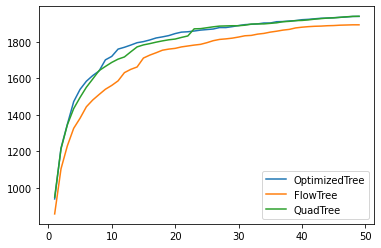

In [20]:

#train_indices = np.load("/data/sam/bbc/train_idx.npy")
train_approx = []
for i in range(3):
    train_approx.append(approximations[i][train_indices][:, train_indices])
recall(train_approx, ot_distances[train_indices][:, train_indices])

In [23]:
name = ["OptTree", "Flowtree", "Quadtree"]

max_pred_accuracy = 0
max_k = 0
for j in range(3):
    print(name[j])
    for i in range(1, 20):
        pred_accuracy = kNN_experiment(approximations[j], all_labels, k = i)
        if pred_accuracy > max_pred_accuracy:
            max_pred_accuracy = pred_accuracy
            max_k = i
    print("Prediction accuracy:", pred_accuracy, "k = ", max_k)
    print("kNN test error:", 1 - pred_accuracy)
#kNN_experiment(approximations, np.array(test_labels), k=15)
for i in range(1, 20):
    pred_accuracy = kNN_experiment(ot_distances, all_labels, k = i)
    if pred_accuracy > max_pred_accuracy:
        max_pred_accuracy = pred_accuracy
        max_k = i
print("Prediction accuracy:", pred_accuracy, "k = ", max_k)
print("kNN test error:",1 - pred_accuracy)

OptTree
Prediction accuracy: 0.7093739863769056 k =  13
kNN test error: 0.29062601362309437
Flowtree
Prediction accuracy: 0.7084009082062925 k =  13
kNN test error: 0.29159909179370747
Quadtree
Prediction accuracy: 0.7054816736944535 k =  13
kNN test error: 0.29451832630554653
Prediction accuracy: 0.7019137204022057 k =  13
kNN test error: 0.2980862795977943


In [22]:
name = ["OptTree", "Flowtree", "Quadtree"]
for i in range(3):
    print(name[i], svm(approximations[i], all_labels, train_indices))
print("OT indefinite kernel", svm(ot_distances, all_labels, train_indices))

OptTree 0.7254054054054054
Flowtree 0.7264864864864865
Quadtree 0.7135135135135136
OT indefinite kernel 0.7286486486486486
